# [DeepSphere]: a spherical convolutional neural network
[DeepSphere]: https://github.com/SwissDataScienceCenter/DeepSphere

[Nathanaël Perraudin](https://perraudin.info), [Michaël Defferrard](http://deff.ch), Tomasz Kacprzak, Raphael Sgier

# Demo: spherical convolution

In this small notebook, we test an implementation of a spherical convolution. The general idea is to use a graph instead of the tradtionial 2 dimensional grid as a support for convolution.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import healpy as hp
import pygsp as pg

from deepsphere import utils, plot

In [3]:
plt.rcParams['figure.figsize'] = (17, 5)  # (9, 4) for matplotlib notebook

## 1 Graph

Let us start by constructing two small graphs on the healpix sampling scheme and visualizing them (with and without edges).

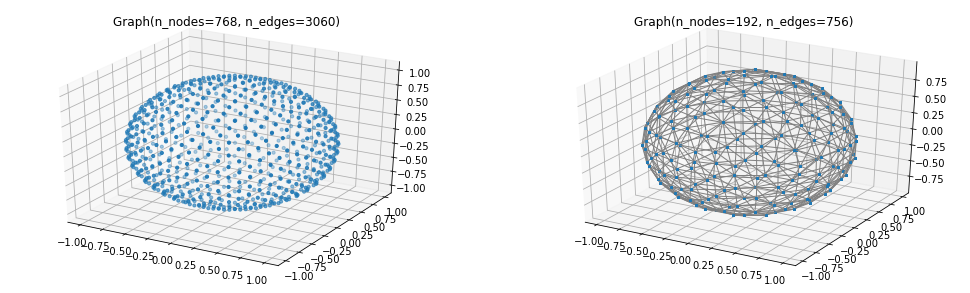

In [4]:
fig = plt.figure()

ax = fig.add_subplot(121, projection='3d')
G = utils.healpix_graph(nside=8, nest=True)
G.plotting.update(vertex_size=10)
G.plot(edges=False, ax=ax)

ax = fig.add_subplot(122, projection='3d')
G = utils.healpix_graph(nside=4, nest=True)
G.plotting.update(vertex_size=20)
G.plot(ax=ax)

The healpix sampling induces an 8 nearest neighbors graph, i.e. a graph where each vertex is connected to 8 vertices. Some vertices are however connected to 7 neighbors only.

In [5]:
for i in np.unique(G.d):
    print('Number of nodes with {} neighbors: {}'.format(i, np.sum(G.d == i)))

Number of nodes with 7 neighbors: 24
Number of nodes with 8 neighbors: 168


## 2 Fourier basis

Graph convolution is defined as the pointwise multiplication in the graph spectral domain. Hence it is important to verify the spectral property of the graph. Note that this operation requires the diagonalization of the Laplacian, which is very costly in computations and mermory. Nevertheless, when it comes to convolution, their exist fast methods that only require sparse matrix multiplications.

In [6]:
G = utils.healpix_graph(nside=16, lap_type='normalized', nest=True, dtype=np.float64)

print('max weighted degree: {:.2f}'.format(G.dw.max()))
print('min weighted degree: {:.2f}'.format(G.dw.min()))
print('mean weighted degree: {:.2f}'.format(G.dw.mean()))
print('Is the graph directed? {}'.format(G.is_directed()))
print('Number of nodes: {}'.format(G.N))

max weighted degree: 5.04
min weighted degree: 4.47
mean weighted degree: 4.95
Is the graph directed? False
Number of nodes: 3072


The eigenvectors are obtained by diagonalizing the graph laplacian defined as $L=I-D^{\frac{1}{2}}WD^{\frac{1}{2}}$, where $W$ is the weight/adjacency matrix and $D$ the degree matrix. 

The Fourier basis $U$ by definition satisfies
$$ L  = U \Lambda U^*. $$
Here the eigenvalues contained in the diagonal of $\Lambda$ somehow correspond to the graph squared frequencies.

In [7]:
# Compute all eigenvectors.
G.compute_fourier_basis()

2019-02-26 11:18:30,915:[WARNING](pygsp.graphs.graph.compute_fourier_basis): Computing the full eigendecomposition of a large matrix (3072 x 3072) is expensive. Consider decreasing n_eigenvectors or, if using the Fourier basis to filter, using a polynomial filter instead.


In [8]:
print('Mean: {}'.format(np.mean(np.abs(G.U.ravel()))))
print('Min: {}'.format(np.min(G.U.ravel())))
print('Max: {}'.format(np.max(G.U.ravel())))
print('Perline: {}'.format(np.max(G.U, axis=1)))

Mean: 0.013599637766632429
Min: -0.27395871553148804
Max: 0.27395871553150863
Perline: [0.08353808 0.07321159 0.07321159 ... 0.07275194 0.07275194 0.08690491]


Let us display a few Fourier modes on the healpix map.

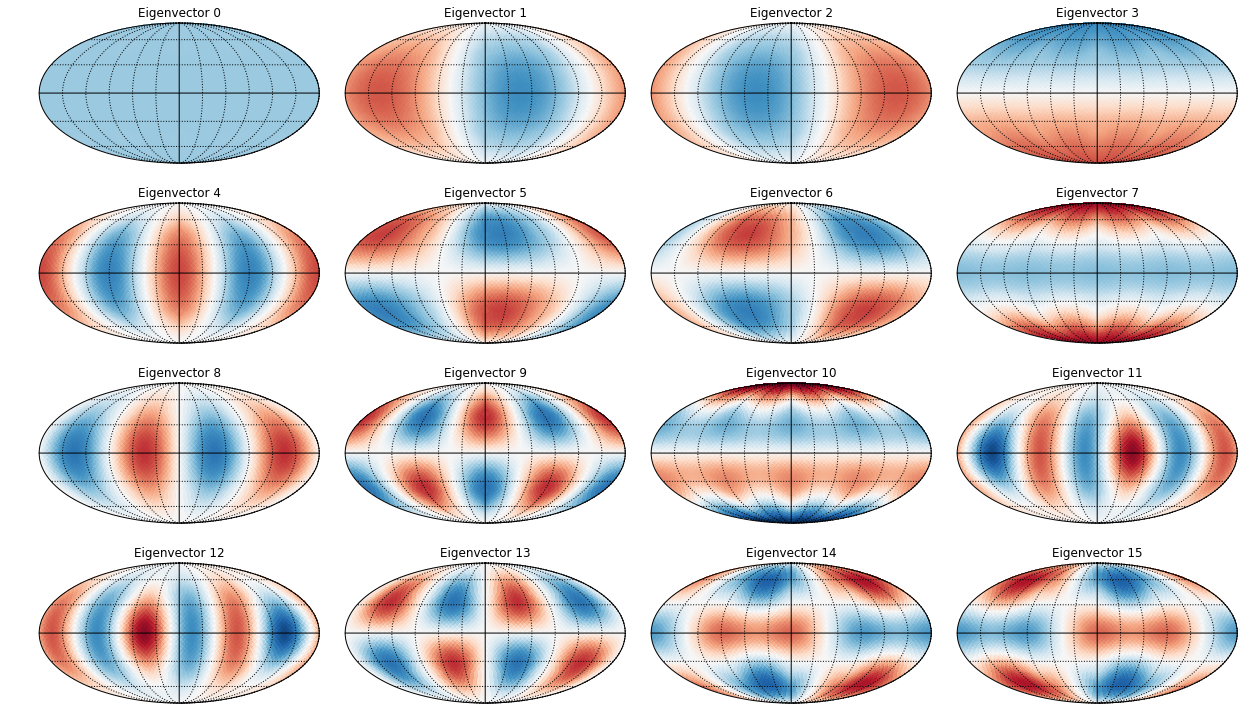

In [9]:
fig = plt.figure(figsize=(17, 10))
ne = 16
cm = plt.cm.RdBu_r
cm.set_under('w')

for ind in range(ne):
    hp.mollview(G.U[:, ind], 
                title='Eigenvector {}'.format(ind), 
                nest=True, 
                sub=(ne//4, 4, ind+1),
                max=np.max(np.abs(G.U[:, :ne])),
                min=-np.max(np.abs(G.U[:, :ne])),
                cbar=False,
                cmap=cm,
                rot=(0,0,0))
with utils.HiddenPrints():
    hp.graticule();


We should also check higher frequency modes as they can be more localized.

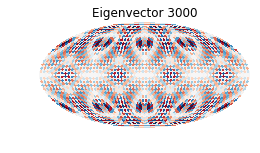

In [10]:
IND = 3000
fig = plt.figure(figsize=(3, 2))
hp.mollview(G.U[:, IND], title="Eigenvector {}".format(IND), nest=True, cbar=False, sub=(1, 1, 1), cmap=cm)

The most localized eigenvector is considered to be the one with the heighest coherence.

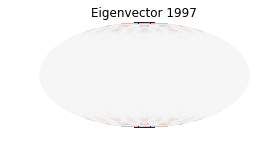

In [11]:
ind = np.argmax(np.max(np.abs(G.U), axis=0))
fig = plt.figure(figsize=(3, 2))
hp.mollview(G.U[:, ind], title="Eigenvector {}".format(ind), nest=True, cbar=False, sub=(1, 1, 1), cmap=cm)

This eigenvector is clearly very localized. Let us display the modulus of the Fourier eigenvector to have a more general idea about all eigenvectors.

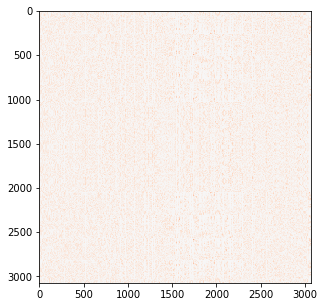

In [12]:
fig = plt.figure()
plt.imshow(np.abs(G.U), cmap=cm, vmin=-np.max(np.abs(G.U)), vmax=np.max(np.abs(G.U)));

### Embedding the data into a 3D space using the eigenvectors

We clearly see that the eigenvectors capture the spherical geometry.

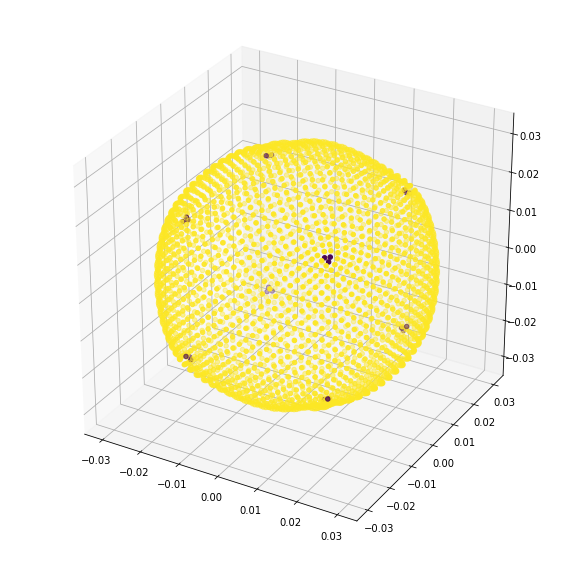

In [13]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(G.U[:, 1], G.U[:, 2], G.U[:, 3], c=G.d);

## 3 Convolution on graphs

The convolution of a signal $f$ and a kernel $k(x)$ on a graph is defined as the pointwise multiplication in the spectral domain, i.e.
$$f_c  = U k(\Lambda)U^*f. $$
Here $U^*f$ is the graph Fourier transform of $f$ and $k(\Lambda)$ is a diagonal matrix where the kernel $k$ is applied on each element of the diagonal of $\Lambda$. 

Let us start with the heat diffusion problem. We solve the following equation on the graph:
$$ L f(t) = \tau \partial_t f(t),$$
where $f(t): \mathbb{R}_+ \rightarrow \mathbb{R}^N$ is a multivariate function depending on the time, $L$ a positive semi-definite matrix representing the Laplacian of a graph, and $\tau$ a constant.

Given the vector $f_0 = f(0)$, the solution of this equation for time $t$ can be written as:
$$ f(t) = K_t(L) f_0, $$
where 
$$ K_t(L) = e^{-\tau t L}.$$
In the equation $f(t) = K_t(L) f_0$, the kernel $K_t(x)=e^{-\tau t x}$ can be considered as the convolution kernel and the heat diffusion problem can be solved using a simple convolution on the graph.

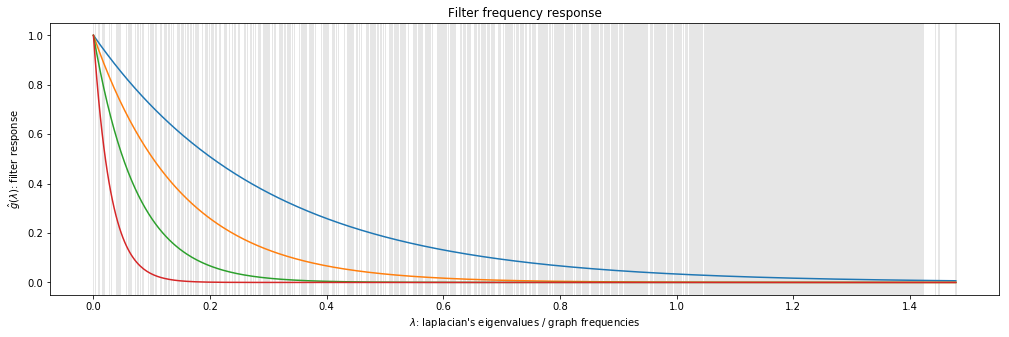

In [14]:
taus = [5, 10, 20, 50]
hf = pg.filters.Heat(G, tau=taus)
fig, ax = plt.subplots()
hf.plot(eigenvalues=True, sum=False, ax=ax)
ax.set_title('Filter frequency response');

[0.10418301085906113, 0.05678146813759494, 0.0480335868213286, 0.03807774582666012]


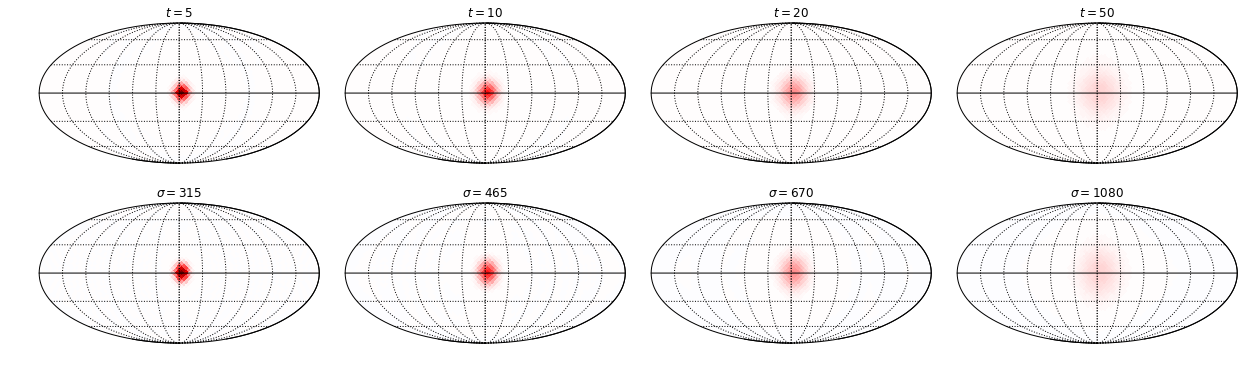

In [15]:
def arcmin2rad(x):
    return x / 60 / 360 * 2 * np.pi

def gaussian_smoothing(sig, sigma, nest=True):
    with utils.HiddenPrints():
        if nest:
            sig = hp.reorder(sig, n2r=True)
        smooth = hp.sphtfunc.smoothing(sig, sigma=arcmin2rad(sigma))
        if nest:
            smooth = hp.reorder(smooth, r2n=True)
        return smooth
_, center = plot.get_index_equator(hp.npix2nside(G.N), radius=20)
ind0 = center
sig = np.zeros(G.N)
sig[ind0] = 1
conv = hf.analyze(sig)

fig = plt.figure()
rel_diff = []
cm = plt.cm.seismic
# cm = plt.cm.jet
cm.set_under('w')
m = 0
for i, (tau, sigma) in enumerate(zip(taus, [315, 465, 670, 1080])):
    smooth = gaussian_smoothing(sig, sigma, nest=True)
    m = max(m, max(smooth))
    hp.mollview(conv[:, i], 
                title='$t={}$'.format(tau), 
                nest=True, 
                min=-m, max=m,
                cbar=False,
                rot=(180,0,180),
                sub=(2, len(taus), i+1),
                cmap=cm)
    
    hp.mollview(smooth, 
                title='$\sigma={}$'.format(sigma), 
                nest=True, 
                min=-m, max=m,
                cbar=False,
                rot=(180,0,180),
                sub=(2,len(taus),i+len(taus)+1),
                cmap=cm)
    
    diff = (conv[:, i]-smooth)
    rel_diff.append(np.linalg.norm(diff)/np.linalg.norm(smooth))

with utils.HiddenPrints():
    hp.graticule();

print(rel_diff)

## 4 Smoothing a Planck map

Let us play with a Planck map.

In [16]:
folder = 'data'
name = 'COM_CMB_IQU-smica_1024_R2.02_full.fits'
if not os.path.exists(os.path.join(folder, name)):
    url = 'https://irsa.ipac.caltech.edu/data/Planck/release_2/all-sky-maps/maps/component-maps/cmb/' + name
    utils.download(url, folder, name)

In [17]:
map_cmb, map_noise, map_mask = hp.read_map('data/COM_CMB_IQU-smica_1024_R2.02_full.fits', field=(0, 1, 3), nest=True)

NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/home/gusset/miniconda3/envs/spheremod/lib/python3.6/site-packages/healpy/fitsfunc.py:326: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


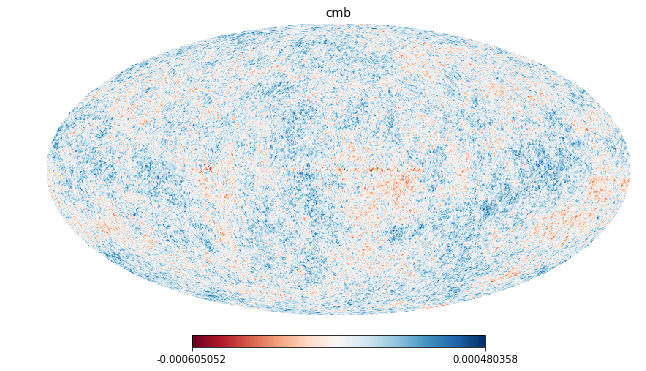

In [18]:
cm = plt.cm.RdBu
cm.set_under('w')

hp.mollview(map_cmb, title='cmb', nest=True, cmap=cm)

Let us first downsample the map in order to make the smoothing operation more visible.

In [19]:
nside = 256
map_cmb_lores = hp.ud_grade(map_cmb, nside_out=nside, order_in='NESTED')
G = utils.healpix_graph(nside=nside, nest=True)
G.estimate_lmax()

Let apply our heat operator. It will smooth the map.

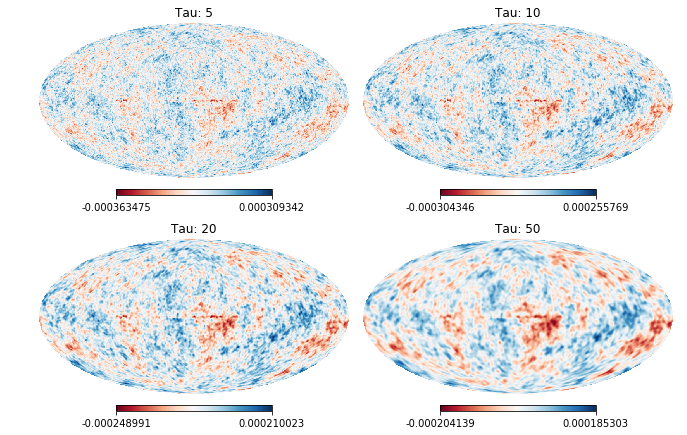

In [20]:
taus = [5, 10, 20, 50]
hf = pg.filters.Heat(G, tau=taus)
conv_map_lowres = hf.analyze(map_cmb_lores)

fig = plt.figure(figsize=(9, 6))
for i, tau in enumerate(taus):
    hp.mollview(conv_map_lowres[:, i], 
                title="Tau: {}".format(tau), 
                nest=True, 
                cmap=cm,
                sub=(np.sqrt(len(taus)), np.sqrt(len(taus)), i+1))

## 5 Power spectral density

Let us now compute the power spectral density on the sphere. This is going to be different than the one based on the spherical harmonics.

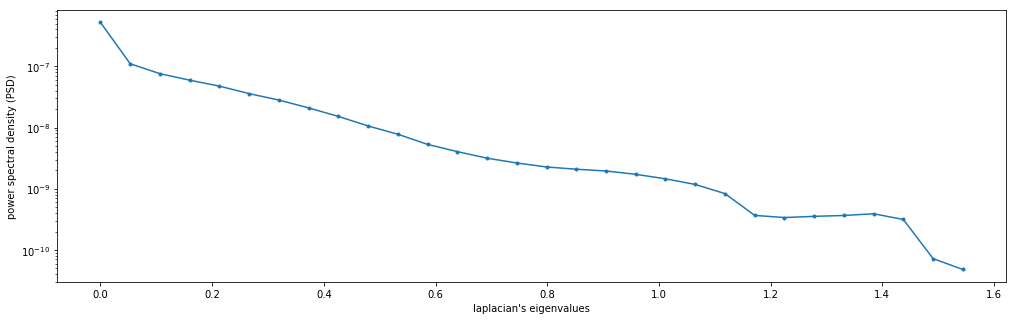

In [21]:
def estimate_graph_psd(graph, signal, n_rand=10, n_point=30):
    """Estimate the power spectral density on graph.
    
    Parameters
    ----------
    graph : pygsp.graphs.Graph
    signal : numpy.ndarray
        Signal whose PSD is to be estimated.
    n_rand : int
        Number of random signals used for the estimation.
    n_point : int
        Number of points at which the PSD is estimated.
    
    Returns
    -------
    spectrum : numpy.ndarray
        Points at which the PSD was estimated.
    psd : numpy.ndarray
        Power spectral density (PSD) at the evaluation points.
    """
    
    # Define filterbank.
    g = pg.filters.Itersine(graph, Nf=n_point, overlap=2)
    spectrum = np.linspace(0, graph.lmax, n_point)
    
    # Filter signal.
    sig_filt = g.filter(signal, method='chebyshev', order=2*n_point)
    sig_dist = np.sum(sig_filt**2, axis=0)
    if sig_dist.ndim > 1:
        sig_dist = np.mean(sig_dist, axis=0).squeeze()
    
    # Estimate the eigenvectors by filtering random signals.
    rand_sig = np.random.binomial(n=1, p=0.5, size=[graph.N, n_rand]) * 2 - 1
    rand_sig_filered = g.filter(rand_sig, method='chebyshev', order=2*n_point)
    eig_dist = np.mean(np.sum(rand_sig_filered**2, axis=0), axis=0).squeeze()
    
    # Compute PSD.
    psd_values = sig_dist / eig_dist
    
    return spectrum, psd_values

spectrum, psd = estimate_graph_psd(G, map_cmb_lores, n_rand=5, n_point=30)

fig, ax = plt.subplots()
ax.semilogy(spectrum, psd, '.-');
ax.set_xlabel("laplacian's eigenvalues");
ax.set_ylabel('power spectral density (PSD)');